In [3]:
# pip install spacy
# python -m spacy download it_core_news_sm

import os
import re
import pandas as pd
from nltk.corpus import stopwords
import spacy
import math
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

### Utils

In [39]:
stop_words = set(stopwords.words('italian')) #remove stop words
lemmatizer = spacy.load('it_core_news_sm')

def pre_processing(document):
    document = re.sub(r'[^\w\s]',' ',document) #remove punctuation
    document = document.lower()
    document = lemmatizer(document)
    document = [token.lemma_ for token in document]
    document = [w for w in document if not w in stop_words]
    return document

#inverse document frequency
def idf(word, documents_list):
    return math.log10(len(documents_list)/sum([1.0 for i in documents_list if word in i.testo]))

#term frequency
def tf(word, document_words):
    return document_words.count(word)/len(document_words)

In [5]:
class Documento:
    # ============================================
    # Constructor
    # ============================================
    def __init__(self, titolo, classe, testo):
        self.titolo = titolo
        self.classe = classe
        self.testo = testo
        self.term_vector = []

    def __str__(self):
        return "Titolo: " + self.titolo + "\nClasse: " + self.classe

### Vector space model

In [6]:
path = "data\docs_200"
documents = []
classi = set()
vocabolario = set()

for file_name in os.listdir(path):
    if os.path.isfile(os.path.join(path, file_name)):
        file = open("data/docs_200/" + file_name, "r", encoding="utf-8")
        classe = file_name.split("_")[0]
        sentence = file.read().replace("\n", " ").replace("\"", "")
        sentence = pre_processing(sentence)
        sentence = sentence[:20]
        document = Documento(file_name, classe, sentence)
        vocabolario.update(document.testo)
        classi.add(file_name.split("_")[0])

        documents.append(document)        

In [7]:
for doc in documents:
    print(doc)
    print('\n')

Titolo: ambiente_01.txt
Classe: ambiente


Titolo: ambiente_02.txt
Classe: ambiente


Titolo: ambiente_03.txt
Classe: ambiente


Titolo: ambiente_04.txt
Classe: ambiente


Titolo: ambiente_05.txt
Classe: ambiente


Titolo: ambiente_06.txt
Classe: ambiente


Titolo: ambiente_07.txt
Classe: ambiente


Titolo: ambiente_08.txt
Classe: ambiente


Titolo: ambiente_09.txt
Classe: ambiente


Titolo: ambiente_10.txt
Classe: ambiente


Titolo: ambiente_11.txt
Classe: ambiente


Titolo: ambiente_12.txt
Classe: ambiente


Titolo: ambiente_13.txt
Classe: ambiente


Titolo: ambiente_14.txt
Classe: ambiente


Titolo: ambiente_15.txt
Classe: ambiente


Titolo: ambiente_16.txt
Classe: ambiente


Titolo: ambiente_17.txt
Classe: ambiente


Titolo: ambiente_18.txt
Classe: ambiente


Titolo: ambiente_19.txt
Classe: ambiente


Titolo: ambiente_20.txt
Classe: ambiente


Titolo: cinema_01.txt
Classe: cinema


Titolo: cinema_02.txt
Classe: cinema


Titolo: cinema_03.txt
Classe: cinema


Titolo: cinema_04.txt
C

In [45]:
for doc in documents:
    weights = {}
    for word in vocabolario:
        weights.update({word: tf(word, doc.testo) * idf(word, documents)})
    doc.term_vector = weights

In [41]:
colori = ["red", "blue", "green", "yellow", "orange", "purple", "pink", "brown", "gray", "black"]

#foreach classe in classi assign a color
colors_list = {}
i = 0
for classe in classi:
    if classe not in colors_list.keys():
        colors_list[classe] = colori[i]
        i += 1 

print(colors_list['economia'])

purple


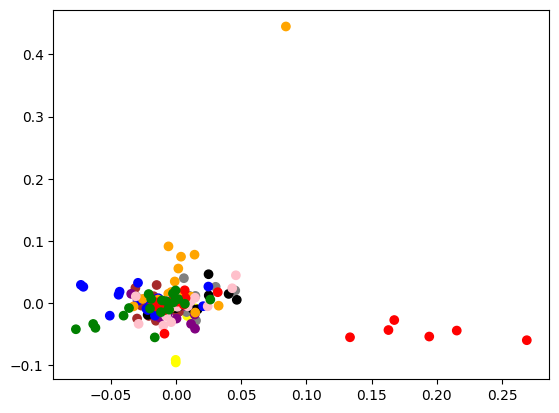

In [42]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#get all document term vectors and assign a color to each class
X = []
color_classes = []
for doc in documents:
    X.append(list(doc.term_vector.values()))
    color_classes.append(colors_list[doc.classe])

#convert to numpy array
X = np.array(X)

#apply PCA
pca = PCA(n_components=2)
X_r = pca.fit_transform(X)

#plot
plt.scatter(X_r[:, 0], X_r[:, 1], c=color_classes)
plt.show()

### Metodo di Rocchio

#### Calcolo dei prototipi (training)

In [12]:
class Prototipo:
    # ============================================
    # Constructor
    # ============================================
    def __init__(self, classe, profile_vector):
        self.classe = classe
        self.profile_vector = profile_vector

    def __str__(self):
        return "Classe: " + self.classe + "\nProfile vector: " + str(self.profile_vector)

In [13]:
def train(documents, classi, beta=4, gamma=16):
    prototipi = []
    for classe in classi:
        prototipi.append(prototipo_rocchio(classe, documents, beta, gamma))

    return prototipi

def prototipo_rocchio(classe, documents, beta, gamma):
    contributi_pos = {}
    contributi_near_pos = {}
    for word in vocabolario:
        contributi_pos.update({word: 0})
        contributi_near_pos.update({word: 0})

    near_pos = near_positive_documents(classe, documents)

    # contributo dei positivi
    count_pos = 0
    for doc in documents:
        if doc.classe == classe:
            for word in vocabolario:
                contributi_pos[word] += doc.term_vector[word]
            count_pos += 1
    for word in vocabolario:
        contributi_pos[word] /= count_pos


    # contributo dei near positive
    count_near_pos = 0
    for n_pos in near_pos:
        for word in vocabolario:
            contributi_near_pos[word] -= n_pos.term_vector[word]
        count_near_pos += 1

    for word in vocabolario:
        contributi_near_pos[word] /= count_near_pos

    # calcolo del prototipo
    prototipo = {}
    for word in vocabolario:
        prototipo[word] = beta * contributi_pos[word] - gamma * contributi_near_pos[word]

 
    return Prototipo(classe, prototipo)

#define method for calculating near_positve documents for rocchio methods
def near_positive_documents(classe_pos, documents):
    near_positive_documents = []
    for doc in documents:
        if doc.classe == classe_pos:
            near_positive_documents.append(get_nearest_doc(doc, documents))

    return near_positive_documents

# restituisce il documento più simile al documento positivo
def get_nearest_doc(positive_doc, documents):
    max_similarity = 0
    nearest_doc = None
    for doc in documents:
        if doc.classe != positive_doc.classe:
            positive_doc_s = np.array(list(positive_doc.term_vector.values())).reshape(1, -1)
            doc_s = np.array(list(doc.term_vector.values())).reshape(1, -1)
            similarity = cosine_similarity(positive_doc_s, doc_s)[0][0]
            if similarity > max_similarity:
                max_similarity = similarity
                nearest_doc = doc
    return nearest_doc
    

In [14]:
prototipo_sport = prototipo_rocchio("sport", documents, 16, 4)

##### cross-validation

In [21]:
def score_rocchio (prototipi, test_set):
    score = 0
    for doc in test_set:
        max_similarity = 0
        for prototipo in prototipi:
            doc_s = np.array(list(doc.term_vector.values())).reshape(1, -1)
            prototipo_s = np.array(list(prototipo.profile_vector.values())).reshape(1, -1)
            similarity = cosine_similarity(doc_s, prototipo_s)[0][0]
            if similarity > max_similarity:
                max_similarity = similarity
                classe = prototipo.classe
        if classe == doc.classe:
            score += 1
    return score/len(test_set)*100


def cross_val_score(documents, classi, cv=5, gamma=16, beta=4):
    scores = []

    #shuffle documents
    documents_permutato = np.random.permutation(documents)

    #divide x in cv parti
    data_folds = np.array_split(documents_permutato, cv)

    for i in range(cv):
        current_data_training_set = np.concatenate(data_folds[:i] + data_folds[i+1:], axis=0)
        current_data_test_set = data_folds[i]

        prototipi = train(current_data_training_set, classi, gamma, beta)
        score = score_rocchio(prototipi, current_data_test_set)
        print("Fold " + str(i) + ": " + str(score) + " %")

        scores.append(score)
    
    return scores

In [24]:
cross_val_score(documents, classi, cv=2, gamma=1, beta=0.5)

Fold 0: 39.0 %
Fold 1: 39.0 %


[39.0, 39.0]

#### visualizzazione grafica

In [17]:
prototipi = {}
for classe in classi:
    prototipi[classe] = prototipo_rocchio(classe, documents, 4, 16)

In [18]:
colori = ["red", "blue", "green", "yellow", "orange", "purple", "pink", "brown", "gray", "black"]

#foreach classe in classi assign a color
colors_list_pr = {}
i = 0
for classe in classi:
    if classe not in colors_list_pr.keys():
        colors_list_pr[classe] = colori[i]
        i += 1 

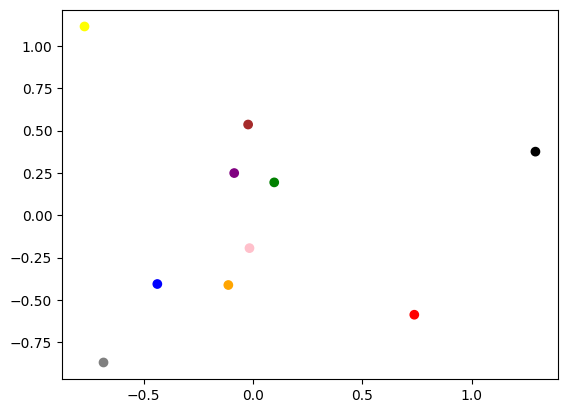

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X = []
color_classes_pr = []
for classe in classi:
    X.append(list(prototipi[classe].profile_vector.values()))
    color_classes_pr.append(colors_list_pr[classe])

#convert to numpy array
X = np.array(X)

#apply PCA
pca = PCA(n_components=2)
X_r = pca.fit_transform(X)

#plot
plt.scatter(X_r[:, 0], X_r[:, 1], c=color_classes_pr)
plt.show()